In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('/Users/haixiangliu/Documents/水质数据及代码模型/water_clean_data.csv')

In [3]:
data.columns = ['datetime','water_level','do','miss','input_wind_throughput','input_wind_openness','ts','input_water_cod','output_water_cod','input_water_ammonia','output_water_ammonia','input_water_ph','output_water_phosphorus','input_water_ss','output_water_ss']

In [4]:
data[['input_wind_throughput','input_wind_openness','input_water_cod','output_water_cod','output_water_ammonia','input_water_ss','output_water_ss']]=data[['input_wind_throughput','input_wind_openness','input_water_cod','output_water_cod','output_water_ammonia','input_water_ss','output_water_ss']].astype(float)

In [5]:
data['year'] = pd.to_datetime(data['datetime']).dt.year
data['month'] = pd.to_datetime(data['datetime']).dt.month
data['weekofyear'] = pd.to_datetime(data['datetime']).dt.weekofyear
data['hour'] = pd.to_datetime(data['datetime']).dt.hour
data[['year','month','weekofyear','hour']]= data[['year','month','weekofyear','hour']].astype(float)
data_basic = data

In [6]:
rolling_features_input_cols = ['do', 'miss', 'input_wind_throughput', 'input_wind_openness',
                    'input_water_cod', 'output_water_cod', 'input_water_ammonia', 
                    'output_water_ammonia', 'input_water_ph', 'output_water_phosphorus', 
                    'input_water_ss', 'output_water_ss']
lags = [3, 7, 14, 30]

In [7]:
data=data.sort_values(by=['datetime'])

In [8]:
#均值
for lag_n in lags:
    for col_name in rolling_features_input_cols:
        data_basic[col_name+'_rollingmean_'+str(lag_n)]=data[col_name].rolling(window=lag_n).mean()

water_rollingmean=data_basic[['ts']+list(s for s in data_basic.columns if 'rollingmean' in s)]

In [9]:
#最小值
for lag_n in lags:
    for col_name in rolling_features_input_cols:
        data_basic[col_name+'_rollingmin_'+str(lag_n)]=data[col_name].rolling(window=lag_n).min()
water_rollingmin=data_basic[['ts']+list(s for s in data_basic.columns if 'rollingmin' in s)]

In [10]:
#最大值
for lag_n in lags:
    for col_name in rolling_features_input_cols:
        data_basic[col_name+'_rollingmax_'+str(lag_n)]=data[col_name].rolling(window=lag_n).max()
water_rollingmax=data_basic[['ts']+list(s for s in data_basic.columns if 'rollingmax' in s)]

In [11]:
#标准差
for lag_n in lags:
    for col_name in rolling_features_input_cols:
        data_basic[col_name+'_rollingstd_'+str(lag_n)]=data[col_name].rolling(window=lag_n).std()
water_rollingstd=data_basic[['ts']+list(s for s in data_basic.columns if 'rollingstd' in s)]

In [12]:
#初值-均值
logs = [3,7]
for lag_n in lags:
    for col_name in rolling_features_input_cols:
        data_basic[col_name+'_rollingdiff_'+str(lag_n)]=data[col_name]-data[col_name].rolling(window=lag_n).mean()
water_rollingdiff=data_basic[['ts']+list(s for s in data_basic.columns if 'rollingdiff' in s)]

In [13]:
data_all = pd.merge(data,water_rollingmean,on=['ts'])\
                .merge(water_rollingmin,on=['ts'])\
                .merge(water_rollingmax,on=['ts'])\
                .merge(water_rollingstd,on=['ts'])\
                .merge(water_rollingdiff,on=['ts'])

In [14]:
data_all=data_all.fillna(0)

In [15]:
a=[]
for i in data_all['output_water_cod']:
    a.append(i)
a=a[5:34035]
data_all_label = data_all.drop([34031,34032,34033,34030,34034])
data_all_label['label_5']=a

In [16]:
train = data_all_label.loc[data_all_label['datetime']<"2016-01-01 00:00:00"]
test = data_all_label.loc[data_all_label['datetime']> "2015-12-31 23:59:59"]

In [17]:
train.shape,test.shape

((25442, 260), (8588, 260))

In [18]:
excluded_cols = ['datetime', 'label', 'ts', 'output_water_cod','label_5']
rolling_features = [col for col in data_all.columns if "_rolling" in col]
basic_features = [col for col in data_all.columns if col not in rolling_features + excluded_cols]

In [20]:
rollingmean_features = [col for col in data_all.columns if "_rollingmean" in col]
rollingmax_features = [col for col in data_all.columns if "_rollingmax" in col]
rollingmin_features = [col for col in data_all.columns if "_rollingmin" in col]
rollingdiff_features = [col for col in data_all.columns if "_rollingdiff" in col]
rollingstd_features = [col for col in data_all.columns if "_rollingstd" in col]
features_basic=basic_features+rollingmean_features+rollingdiff_features+rollingstd_features+rollingmax_features+rollingmin_features

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

In [25]:
pipe = Pipeline([('imputer',Imputer()),
                    ('sc', StandardScaler()),
                    ('pca', PCA(n_components=50)),
                    ('rf', RandomForestRegressor(n_estimators=100)) 
                    #('xgbr',XGBRegressor(n_estimators=100))
                     #('dt',DecisionTreeRegressor(max_features=50))
                    ])
model = pipe.fit(train[features_basic],train['label_5'])

In [26]:
predictions = model.predict(train[features_basic])

In [27]:
mean_squared_error(train['label_5'],predictions)

3.0503736420092764

In [28]:
predictions_test = model.predict(test[features_basic])

In [29]:
mean_squared_error(test['label_5'],predictions_test)

30.25309129017234

In [30]:
%matplotlib inline 
import matplotlib.pyplot as plt

In [31]:
test.columns

Index(['datetime', 'water_level', 'do', 'miss', 'input_wind_throughput',
       'input_wind_openness', 'ts', 'input_water_cod', 'output_water_cod',
       'input_water_ammonia',
       ...
       'input_wind_openness_rollingdiff_30', 'input_water_cod_rollingdiff_30',
       'output_water_cod_rollingdiff_30', 'input_water_ammonia_rollingdiff_30',
       'output_water_ammonia_rollingdiff_30', 'input_water_ph_rollingdiff_30',
       'output_water_phosphorus_rollingdiff_30',
       'input_water_ss_rollingdiff_30', 'output_water_ss_rollingdiff_30',
       'label_5'],
      dtype='object', length=260)

In [35]:
predictions= predictions[0:500]
train_label=[]
num=0
for i in train['label_5'].head(500).astype(float):
     train_label.append(i)

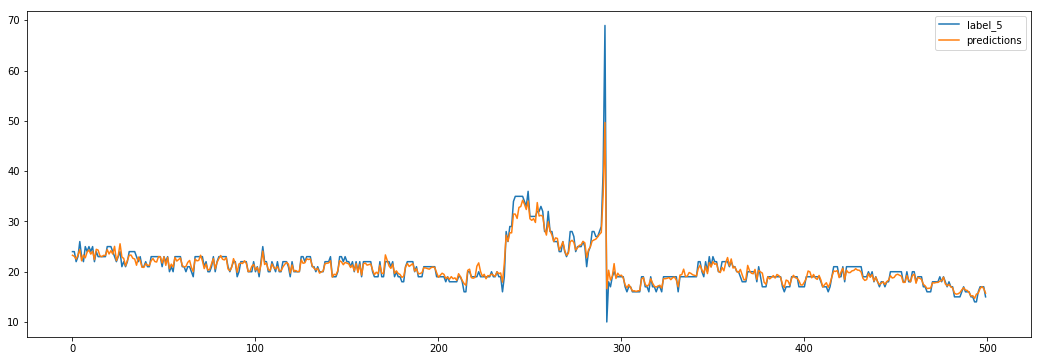

In [36]:
plt.plot(train_label,label='label_5')
plt.plot(predictions,label='predictions')
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.legend()

In [32]:
predictions_label = predictions_test[0:500]
test_label=[]
num=0
for i in test['label_5'].head(500).astype(float):
     test_label.append(i)

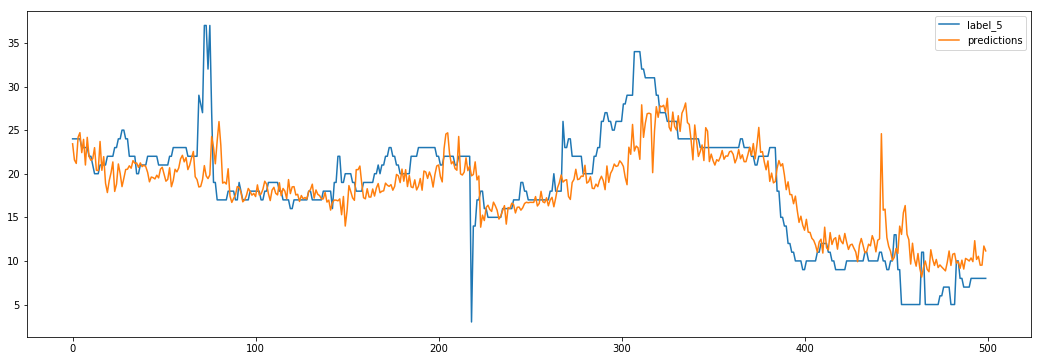

In [34]:
plt.plot(test_label,label='label_5')
plt.plot(predictions_label,label='predictions')
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.legend()

In [37]:
from sklearn.model_selection import cross_val_score 

In [38]:
print(cross_val_score(model,train[features_basic],train['label_5'],cv=5))

[-2.46176402  0.27360876  0.25821581 -0.29143024  0.35391794]
